<a href="https://colab.research.google.com/github/Sejong-Kaggle-Challengers/jeongmin/blob/main/KCB_%EA%B8%88%EC%9C%B5%EC%8A%A4%ED%83%80%EC%9D%BC_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### KCB(올크레딧) - 신용평가사
다양한 금융사로부터 여신거래 기록, 채무 정보, 연체정보 등  다양한 고객 금융 정보를 받아 전국민 85.4%인 4,400만 경제활동 인구의
경제 활동 데이터를 보유하고 있으며, 이를 통해 개인 신용 등급 책정 및 솔루션/컨설팅 서비스를 제공
<br><br>
대회 목적 :
1. KCB 전국민 금융 데이터의 새로운 인사이트 발굴
2. 활용도 높은 결과물로 금융친화적 콘텐츠 발전에 기여
<br><br>
credit_card_data.csv : 전국민 카드 및 대출 이용통계 데이터
연령대/거주지/성별 구분에 따른 카드 및 대출 이용통계 데이터로, 구분 값 별 카드이용금액 비교, 대출금액 및 대출 특이사항 비교 등이 가능하다.

In [1]:
!unzip data08.zip

Archive:  data08.zip
replace KCB 대회 약관.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace credit_card_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace jeju_financial_life_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
!pip install eli5

In [3]:
!pip install shap

In [4]:
import pandas as pd #분석
import matplotlib.pyplot as plt #시각화
import seaborn as sns #시각화
import numpy as np#분석

#경고메세지 무시
import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline --> Rich output 를 바로 볼 수 있도록 (colab 에서는 굳이 쓰지 않아도 되는 것 같다)
color = sns.color_palette() #팔레트

#모델
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

#Permutation Importance를 통해 변수의 중요도를 알아볼 수 있다.
import eli5
from eli5.sklearn import PermutationImportance

#Shap Value는 실제값과 예측치의 차이를 설명하는 것
import shap

In [5]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [6]:
plt.rcParams["figure.facecolor"] = 'w' # background color = white
plt.rcParams["font.family"] = 'NanumBarunGothic' #글꼴 설정 = 나눔고딕
plt.rcParams['axes.unicode_minus'] = False #그래프에서 마이너스 기호가 깨지지 않고 표시되도록

In [7]:
train = pd.read_csv("credit_card_data.csv")
train.shape

(3888, 26)

In [8]:
train.head()

,pop_cd,year,month,avg_score,avg_rat,city,sex,ages,population,num_opencard,num_usecard,monthly_card_spend,monthly_lc,monthly_loan,monthly_bk_loan,monthly_cd_loan,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,ls_rep_loanb,credit_loan,mortgage_loan,credit_card_payment,credit_card_installments_payment
0,L011,2016,1,812,2,서울,NaN,10대,55000,1.44,1.13,70000,92630000,87350000,85790000,0,0,0,0,1120000,8210000,78020000,92170000,87260000,0,0
1,L011,2016,2,773,4,서울,NaN,10대,380000,1.71,0.96,170000,31140000,28910000,25850000,190000,510000,220000,1020000,680000,4660000,23300000,8260000,42410000,4000,1000
2,L011,2016,3,771,4,서울,NaN,10대,387000,1.75,0.95,190000,30230000,28180000,25110000,170000,490000,210000,1140000,640000,4370000,22930000,8300000,41710000,3000,1000
3,L011,2016,4,770,4,서울,NaN,10대,412000,1.76,0.92,200000,30430000,27710000,24630000,190000,510000,240000,1340000,510000,4770000,22160000,9460000,41040000,4000,1000
4,L011,2016,5,771,4,서울,NaN,10대,414000,1.75,0.94,170000,31210000,27620000,24390000,210000,490000,340000,1490000,640000,4740000,21960000,9660000,40850000,3000,1000


Nan으로 표현된 부분
- 지역별 통계 : city가 값이 있는 경우는 sex가 Nan --> sex = 전체
- 성별 통계 : sex가 값이 있는 경우는 city가 Nan --> city = 전국



In [9]:
#city와 sex에서 Nan값
train.isnull().sum()

pop_cd                                 0
year                                   0
month                                  0
avg_score                              0
avg_rat                                0
city                                 432
sex                                 3456
ages                                   0
population                             0
num_opencard                           0
num_usecard                            0
monthly_card_spend                     0
monthly_lc                             0
monthly_loan                           0
monthly_bk_loan                        0
monthly_cd_loan                        0
monthly_installments_loan              0
monthly_insurance_loan                 0
monthly_sbk_loan                       0
loan_commitment                        0
inst_rep_loanb                         0
ls_rep_loanb                           0
credit_loan                            0
mortgage_loan                          0
credit_card_paym

In [10]:
train['city'] = train['city'].fillna('전국')
train['sex'] = train['sex'].fillna('전체')

- 나이별 통계 --> 연산의 용이성을 위해 숫자로 변환
- 연도, 월 데이터는 python의 datatime 포맷으로 변환하여 새로운 열 year_month로 변환

In [11]:
train['ages'][0][:-1]

'10'

In [12]:
train['ages'] = train['ages'].apply(lambda x:int(x[:-1])).astype(float)
train['year_month'] = pd.to_datetime((train.year*100+train.month).apply(str), format = '%Y%m')
train.drop(['year','month'], axis=1, inplace=True) #원래 year, month 행 drop
#year_month 행을 이전의 year과 month 자리인 행 2번째로 자리를 변경해 train을 완성한다.
train = train[[train.columns[0], 'year_month'] + list(train.columns[1:-1])]

In [13]:
train.head()

,pop_cd,year_month,avg_score,avg_rat,city,sex,ages,population,num_opencard,num_usecard,monthly_card_spend,monthly_lc,monthly_loan,monthly_bk_loan,monthly_cd_loan,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,ls_rep_loanb,credit_loan,mortgage_loan,credit_card_payment,credit_card_installments_payment
0,L011,2016-01-01,812,2,서울,전체,10.0,55000,1.44,1.13,70000,92630000,87350000,85790000,0,0,0,0,1120000,8210000,78020000,92170000,87260000,0,0
1,L011,2016-02-01,773,4,서울,전체,10.0,380000,1.71,0.96,170000,31140000,28910000,25850000,190000,510000,220000,1020000,680000,4660000,23300000,8260000,42410000,4000,1000
2,L011,2016-03-01,771,4,서울,전체,10.0,387000,1.75,0.95,190000,30230000,28180000,25110000,170000,490000,210000,1140000,640000,4370000,22930000,8300000,41710000,3000,1000
3,L011,2016-04-01,770,4,서울,전체,10.0,412000,1.76,0.92,200000,30430000,27710000,24630000,190000,510000,240000,1340000,510000,4770000,22160000,9460000,41040000,4000,1000
4,L011,2016-05-01,771,4,서울,전체,10.0,414000,1.75,0.94,170000,31210000,27620000,24390000,210000,490000,340000,1490000,640000,4740000,21960000,9660000,40850000,3000,1000


- 유니크 갯수 계산을 통한 변수 값의 다양성 분석

In [14]:
train_unique = []
for i in train.columns.values:
  train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = list(train.columns)
unique_train['Unique_value'] = train_unique

In [15]:
unique_train

,Columns,Unique_value
0,pop_cd,162
1,year_month,24
2,avg_score,117
3,avg_rat,3
4,city,17
5,sex,3
6,ages,9
7,population,1077
8,num_opencard,456
9,num_usecard,256


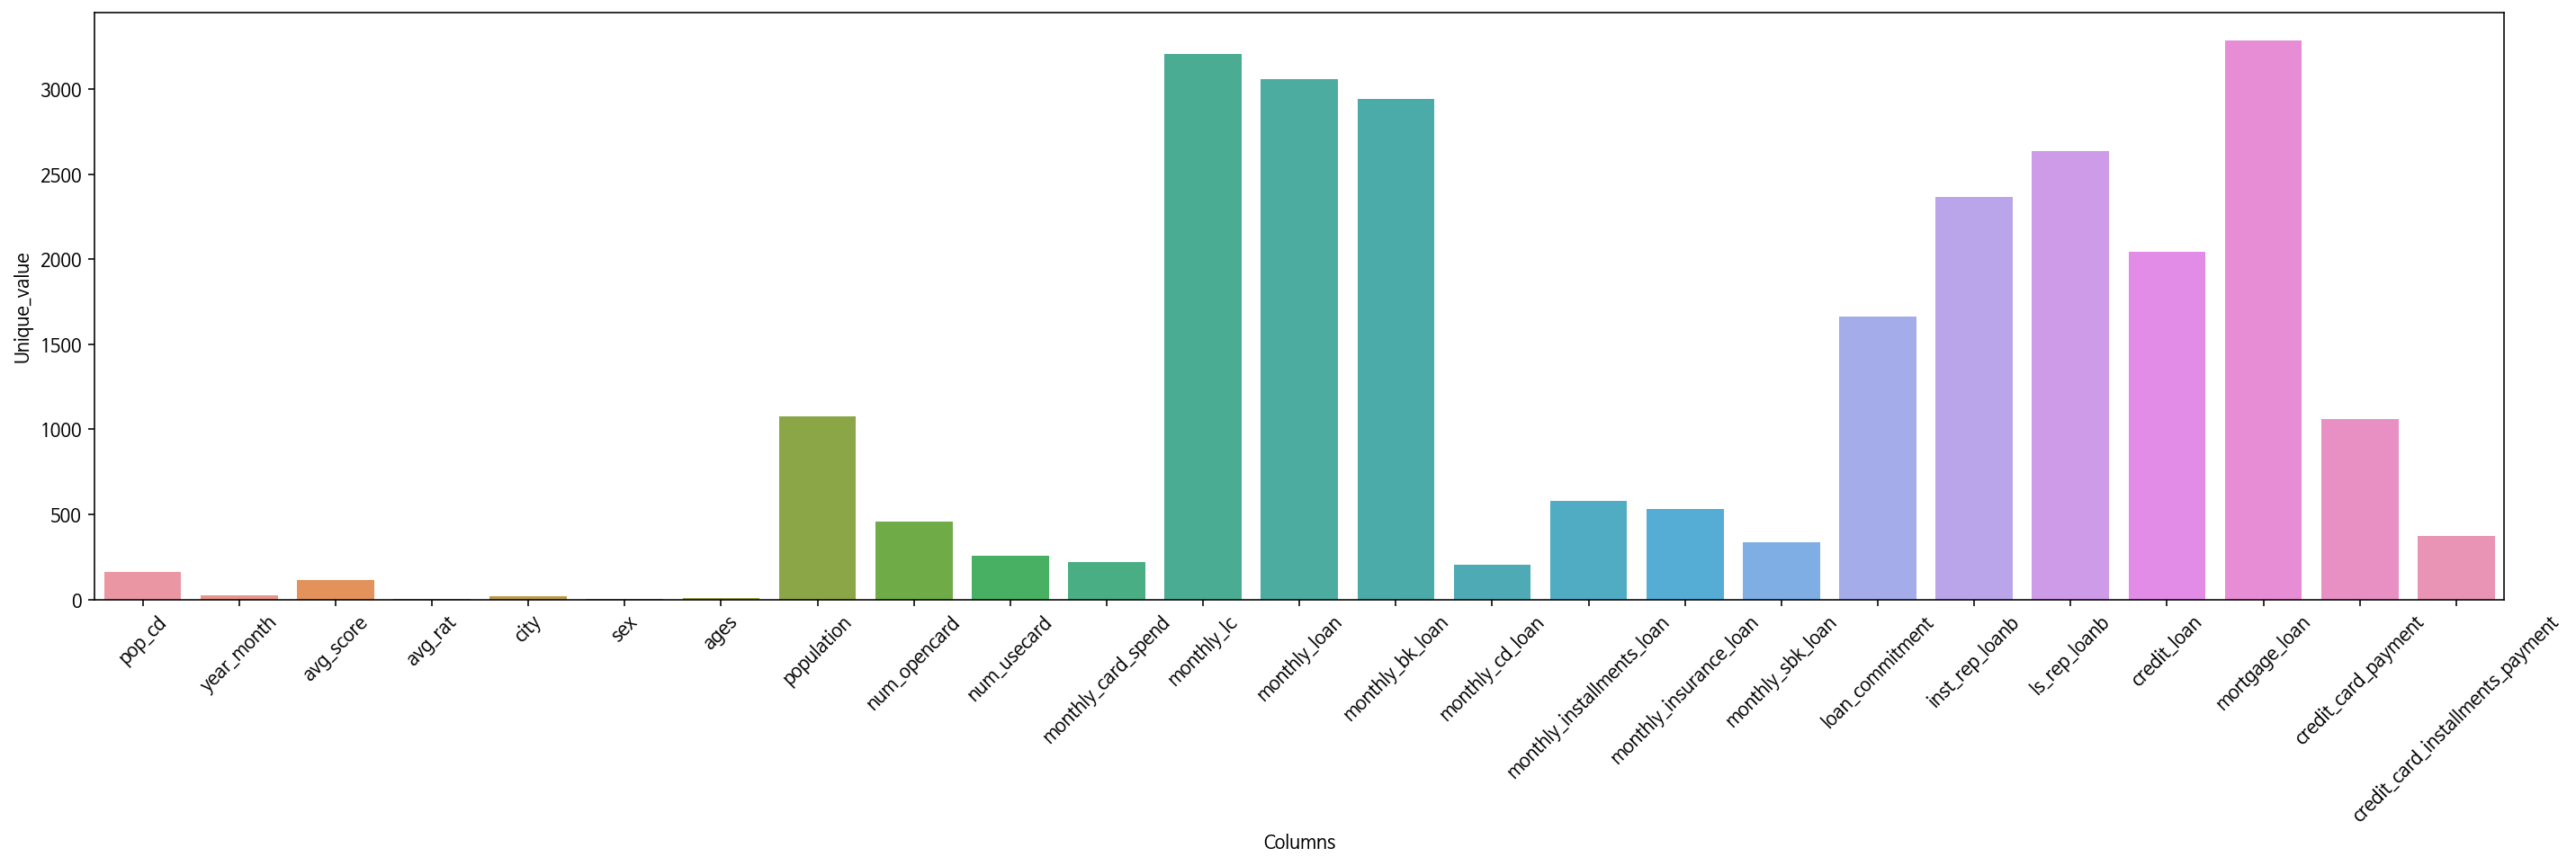

In [16]:
plt.figure(figsize = (24, 6))
sns.barplot(unique_train['Columns'], unique_train['Unique_value'])
xt = plt.xticks(rotation = 45) #x축 column명 45도로 회전시켜 겹치는 것을 피한다.

#원 코드에서는 아래처럼 쓰여있음 --> 이해 제대로 못함..
#xt = plt.xticks()
#_ = plt.xticks(xt[0], train.columns, rotation = 45)

##상관관계 분석
데이터 컬럼 사이의 상관관계를 계산해 비례함의 정도를 보인다.
<br>양의 상관관계가 클 수록 비례관계, 음의 상관관계가 클수록 반비례관계이며<br> 0에 가까우면 서로 독립으로 볼 수 있다.

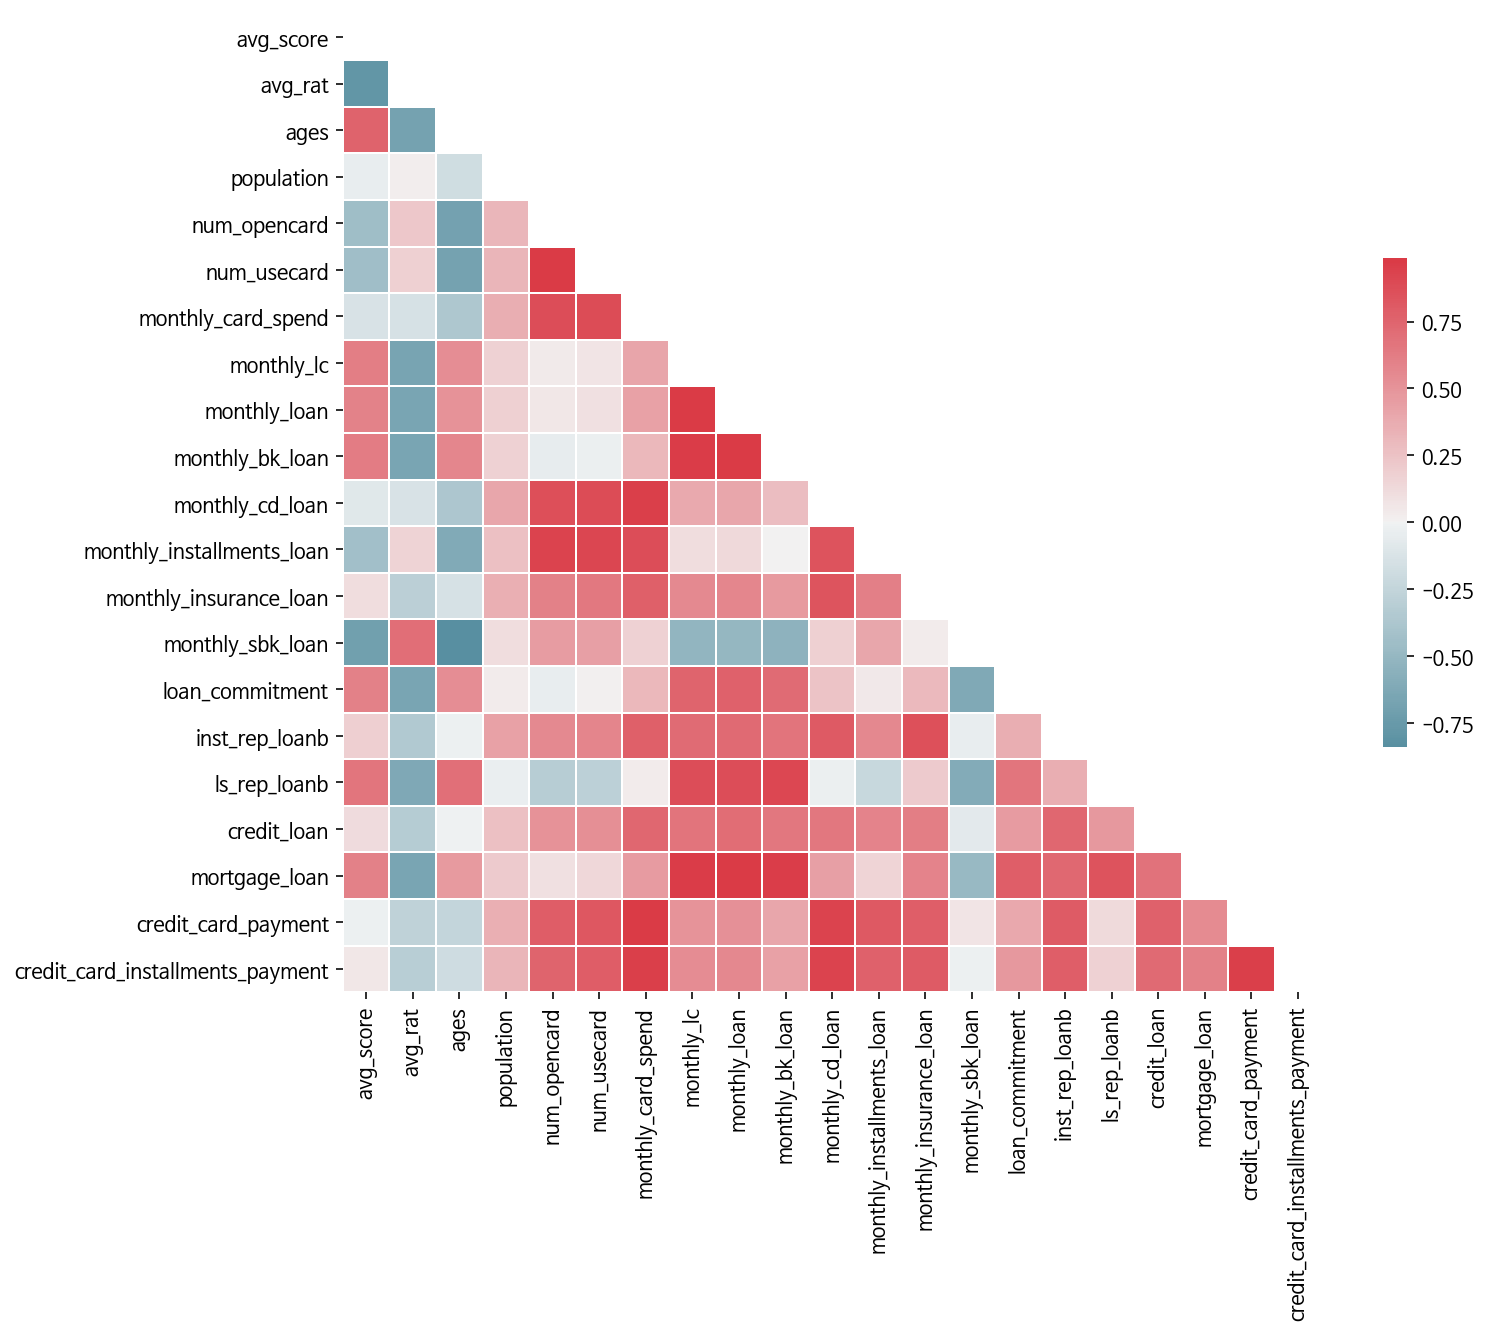

In [17]:
corr = train.corr()

#삼각형 마스크를 만든다.(위쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Heatmap 그리기 - mask and correct aspect ratio  사용
sns.heatmap(corr, mask = mask, cmap = cmap, center = 0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

plt.show()

In [18]:
corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates()
corr.drop(corr.index[0],inplace=True) #credit_card_installments_payment drop

display(corr.head())
display(corr.tail(5))

monthly_loan         monthly_lc            0.986415
credit_card_payment  monthly_card_spend    0.985854
mortgage_loan        monthly_loan          0.985699
num_usecard          num_opencard          0.983744
monthly_loan         monthly_bk_loan       0.980280
dtype: float64

ages              num_usecard        -0.679487
num_opencard      ages               -0.688015
avg_score         monthly_sbk_loan   -0.701963
avg_rat           avg_score          -0.786341
monthly_sbk_loan  ages               -0.841758
dtype: float64

대출 약정 금액 : 최대로 대출 받을 한도를 설정해두고 대출약정금액을 포함한 가격까지 대출이 가능

**양수(+)에서 가장 상관관계가 높은 5쌍**
- monthly_loan(대출 금액), monthly_lc(대출약정금액)  <br>대출금액은 대출약정금액에 포함, 대출약정이 많을수록 대출 발생도 많이 했으므로 마이너스 통장과 같은 대출 발생 금액은 상대적으로 적다고 할 수 있다.
- credit_card_payment(신용카드사용금액),  monthly_card_spend(총카드승인금액) <br>신용카드 사용 금액은 총 카드 승인 금액에 포함, 상관관계가 1에 가깝다는 것은 체크카드 사용량이 적다는 것을 알 수 있다.
- mortgage_loan(담보대출), monthly_loan(대출금액) <br>담보 대출은 대출 금액에 포함, 상관관계가 1에 가깝다는 것은 대출의 상당수가 담보 대출이라는 것을 알 수 있다.
- num_usecard(사용카드수), num_opencard(개설한카드수)<br> 개설한 카드 수와 사용 카드 수가 비례하므로 유휴 카드가 많지 않다고 해석할 수 있다.
- monthly_loan(대출금액)   monthly_bk_loan(은행대출)<br>은행 대출은 대출 금액에 포함, 상관관계가 1에 가깝다는 것은 대출의 상당수가 은행 대출이라는 것을 알 수 있다.

**음수(-)에서 가장 상관관계가 높은 5쌍**
- ages              num_usecard        -0.679487 <br>상관관계에 따르면 나이가 높을수록 사용하는 카드의 수가 적다. 고령으로 갈수록 필요한 카드만 사용한다고 볼 수 있다.
- num_opencard      ages               -0.688015 <br>나이와 사용카드의 관계와 동일하게 해석 가능하다
- avg_score         monthly_sbk_loan   -0.701963 <br>저축은행 대출이 낮을수록 신용점수가 높다.
- avg_rat           avg_score          -0.786341 <br>신용점수가 높을수록 높은 등급을 받는 것은 당연하지만, 등급이 높을수록 숫자가 낮아 음의 상관관계를 가진다.
- monthly_sbk_loan  ages               -0.841758 <br>나이가 낮을수록 저축은행 대출이 높다.

###연령별/지역별 상관관계 분석
전체 데이터의 상관관계가 연령, 지역별로도 적용되는지 확인하기 위해 데이터를 그룹에 따라 모아서 평균 신용점수(avg_score)에 대해서만 상관관계를 분석해보았다.

연령별 상관관계 분석

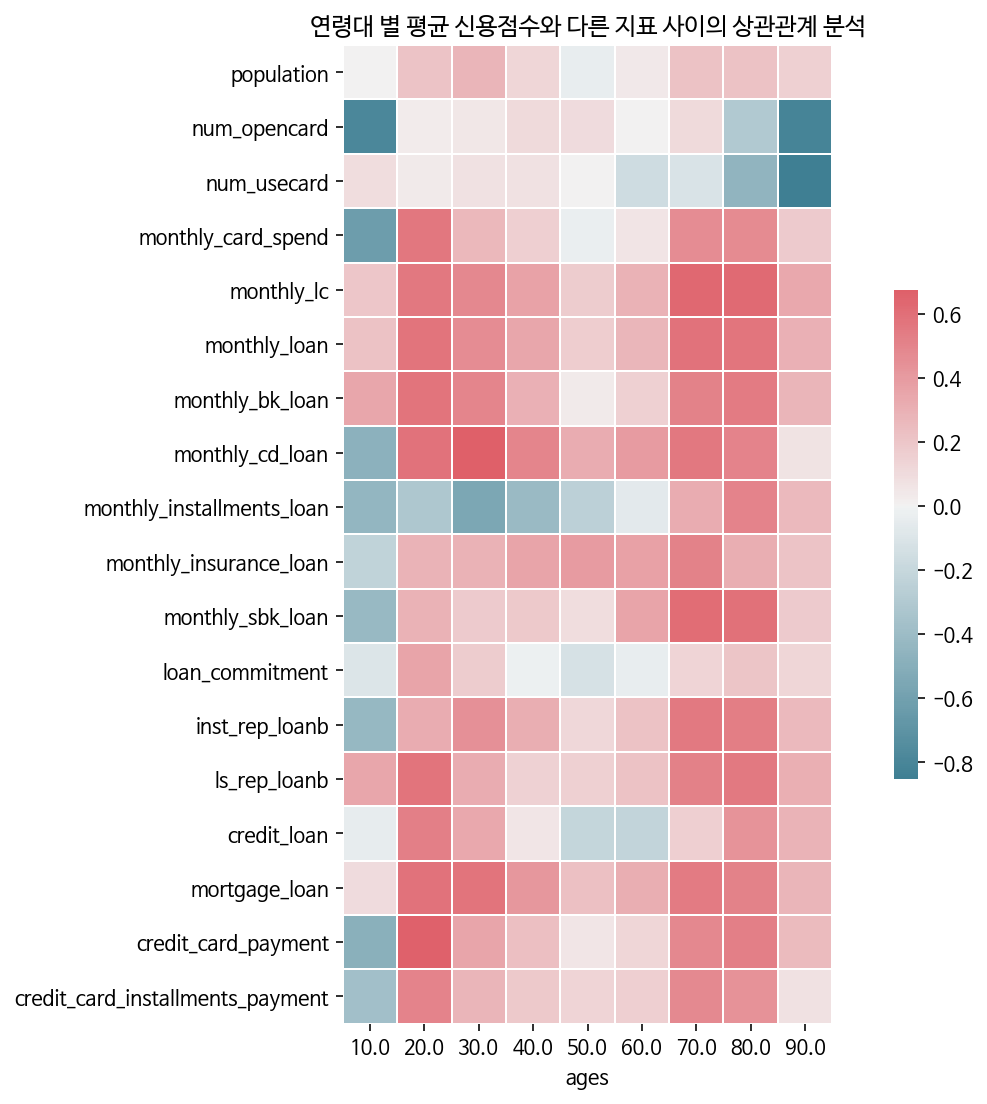

In [19]:
corr = train[train.columns[1:]].groupby('ages').corr()['avg_score'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T[2:],  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('연령대 별 평균 신용점수와 다른 지표 사이의 상관관계 분석')
plt.show()

지역별 상관관계 분석

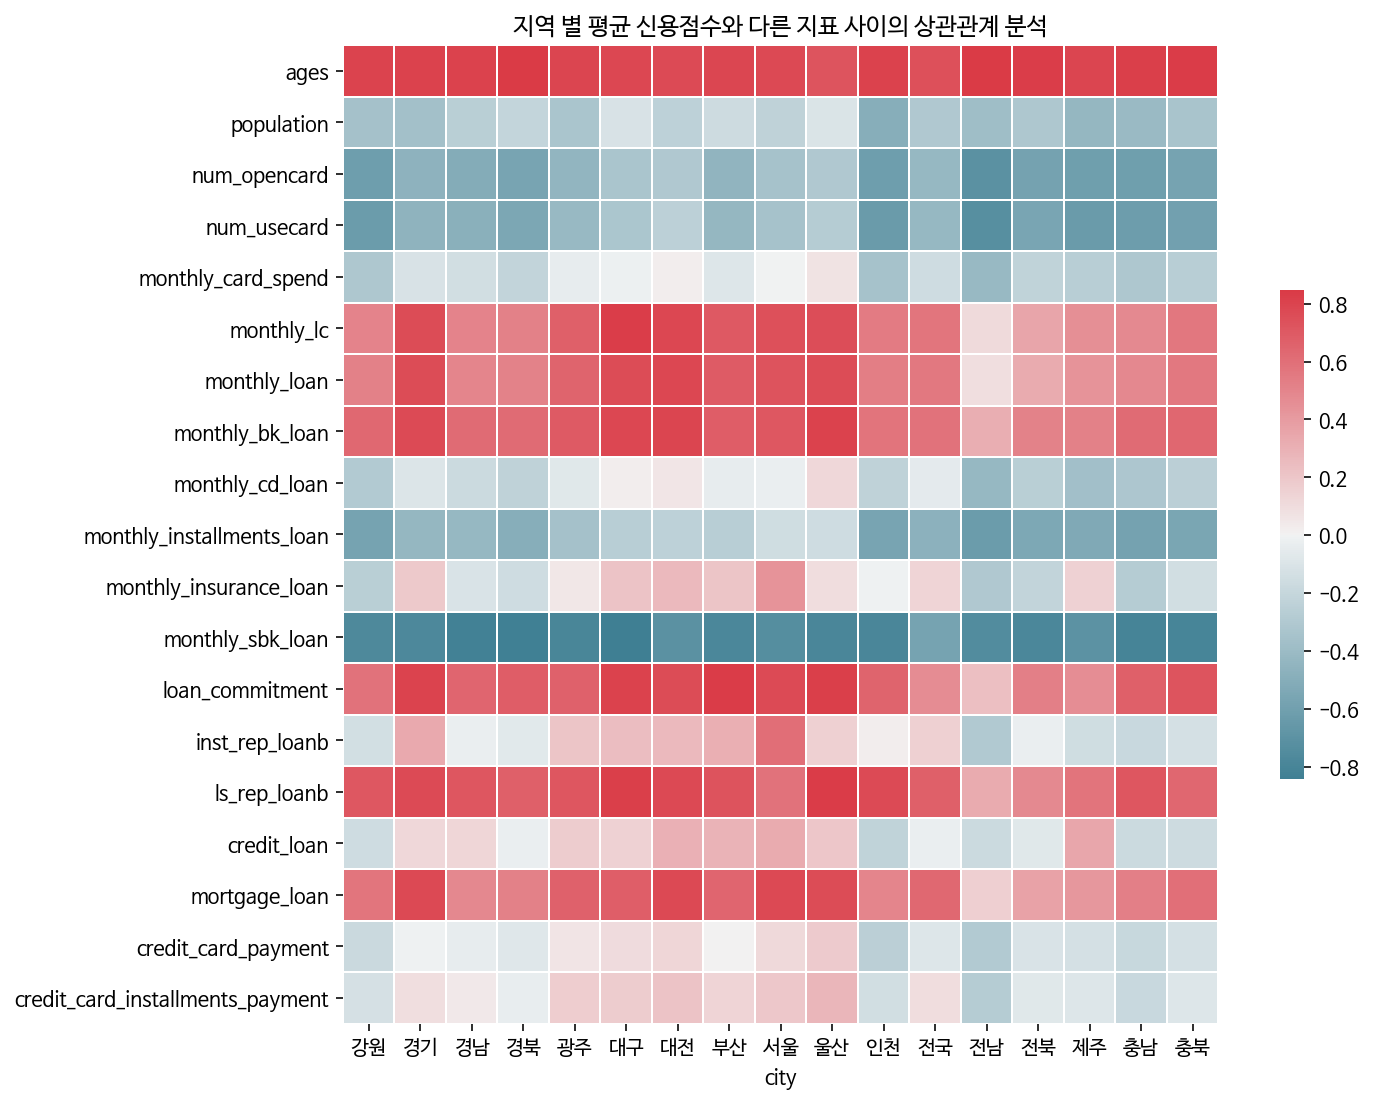

In [20]:
corr = train[train.columns[1:]].groupby('city').corr()['avg_score'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T[2:],  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('지역 별 평균 신용점수와 다른 지표 사이의 상관관계 분석')
plt.show()

위 분석에 따르면 신용점수와의 상관관계는 지역에 따라서는 큰 편차가 없지만 연령에 따라서는 편차가 큰 것으로 보인다.

##신용점수 예측모델 학습 및 분석
신용점수를 예측하는 모델을 학습하여 신용도에 영향을 많이 주는 요소를 분석한다.

- 예측 목표: 'avg_score'
- 학습에 사용되는 요소: 'num_opencard', 'num_usecard', 'monthly_card_spend', 'monthly_lc', 'monthly_loan', 'monthly_bk_loan', 'monthly_cd_loan', 'monthly_installments_loan', 'monthly_insurance_loan', 'monthly_sbk_loan', 'loan_commitment', 'inst_rep_loanb', 'ls_rep_loanb', 'credit_loan', 'mortgage_loan', 'credit_card_payment', 'credit_card_installments_payment'
- 학습에서 제외된 요소: 'pop_cd', 'city', 'ages', 'sex', 'year_month', 'population', 'avg_rat'


###변수 중요도 분석
- Feature Importance: 해당 요소가 데이터를 학습 목적에 맞게 얼마나 잘 나누는지
- Permutation Importance: 해당 요소의 값만 다른 샘플과 임의로 바꾸었을 때 예측 성능이 감소하는 정도

In [21]:
from sklearn.model_selection import train_test_split

target = 'avg_score'
cols_to_drop = ['pop_cd','city','ages', 'sex', 'year_month', 'population','avg_rat', target]
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]
train_split, val_split = train_test_split(train, test_size=0.3)

[10]	valid_0's l2: 48.8816	valid_0's l1: 4.56715
[20]	valid_0's l2: 33.38	valid_0's l1: 3.6491
[30]	valid_0's l2: 26.718	valid_0's l1: 3.05171
[40]	valid_0's l2: 23.1429	valid_0's l1: 2.71218
[50]	valid_0's l2: 20.2312	valid_0's l1: 2.53516
[60]	valid_0's l2: 18.4277	valid_0's l1: 2.38731
[70]	valid_0's l2: 17.9464	valid_0's l1: 2.30331
[80]	valid_0's l2: 17.5407	valid_0's l1: 2.23243
[90]	valid_0's l2: 16.5858	valid_0's l1: 2.15786
[100]	valid_0's l2: 16.2186	valid_0's l1: 2.08287


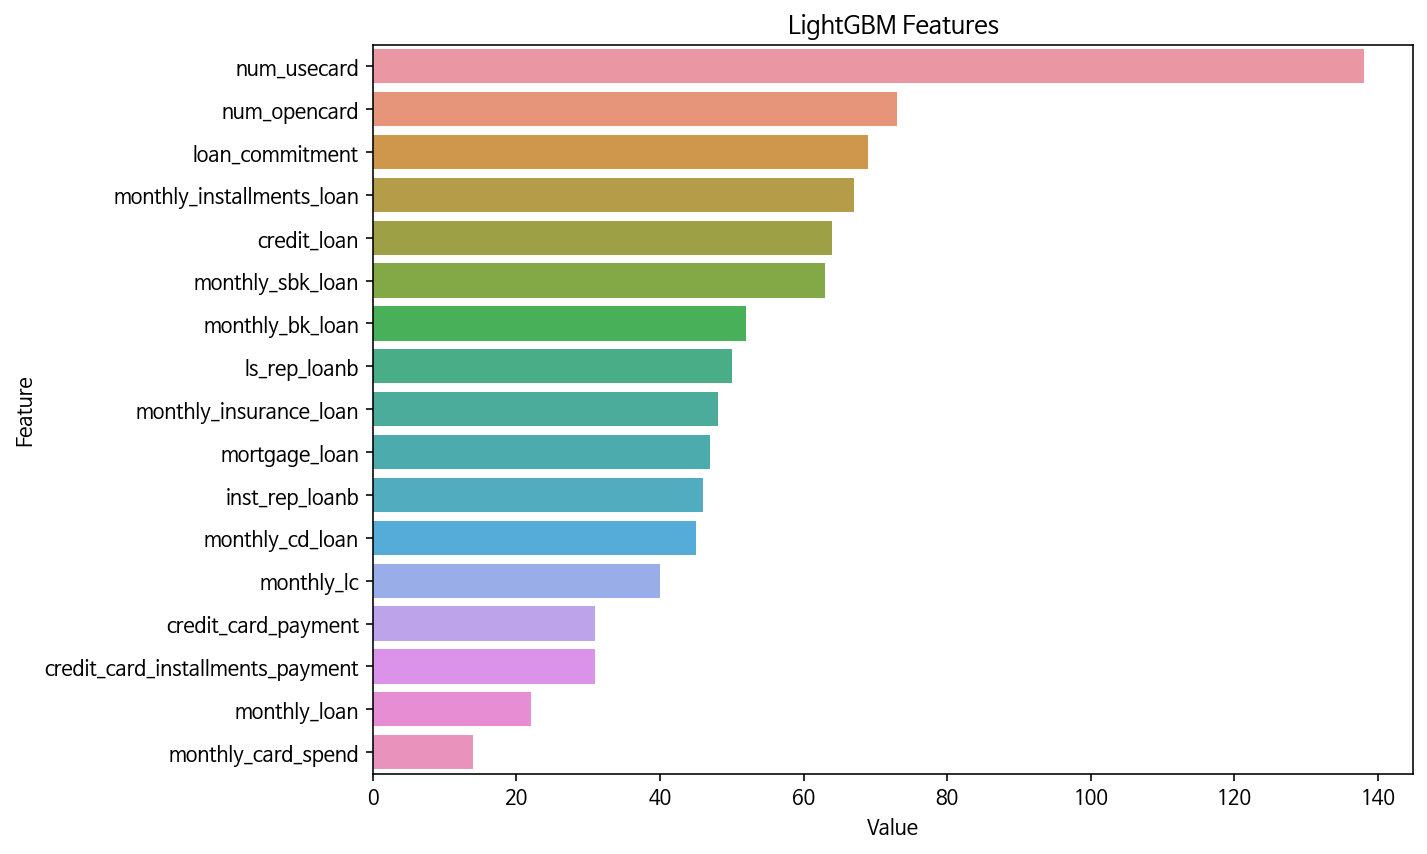

Weight,Feature
1.4403 ± 0.1385,num_usecard
0.2533 ± 0.0201,ls_rep_loanb
0.2359 ± 0.0333,num_opencard
0.1944 ± 0.0121,monthly_installments_loan
0.1103 ± 0.0017,monthly_sbk_loan
0.1018 ± 0.0094,monthly_cd_loan
0.0747 ± 0.0053,monthly_bk_loan
0.0424 ± 0.0060,loan_commitment
0.0345 ± 0.0017,inst_rep_loanb
0.0311 ± 0.0038,credit_card_payment


In [22]:
from lightgbm import LGBMRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 10,
    'objective': 'regression_l2', 
    'metric': ['mae', 'mse'],
    'verbose': -1,
}

lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    eval_metric=['mae', 'mse'],
    verbose=10,
)

feature_importance = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

perm = PermutationImportance(lgbm_model).fit(val_split[cols_to_fit], val_split[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

[12:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:561.102
[10]	validation_0-rmse:18.7808
[20]	validation_0-rmse:8.16581
[30]	validation_0-rmse:6.77417
[40]	validation_0-rmse:6.09394
[50]	validation_0-rmse:5.67145
[60]	validation_0-rmse:5.36367
[70]	validation_0-rmse:5.12057
[80]	validation_0-rmse:4.90335
[90]	validation_0-rmse:4.75596
[99]	validation_0-rmse:4.68045


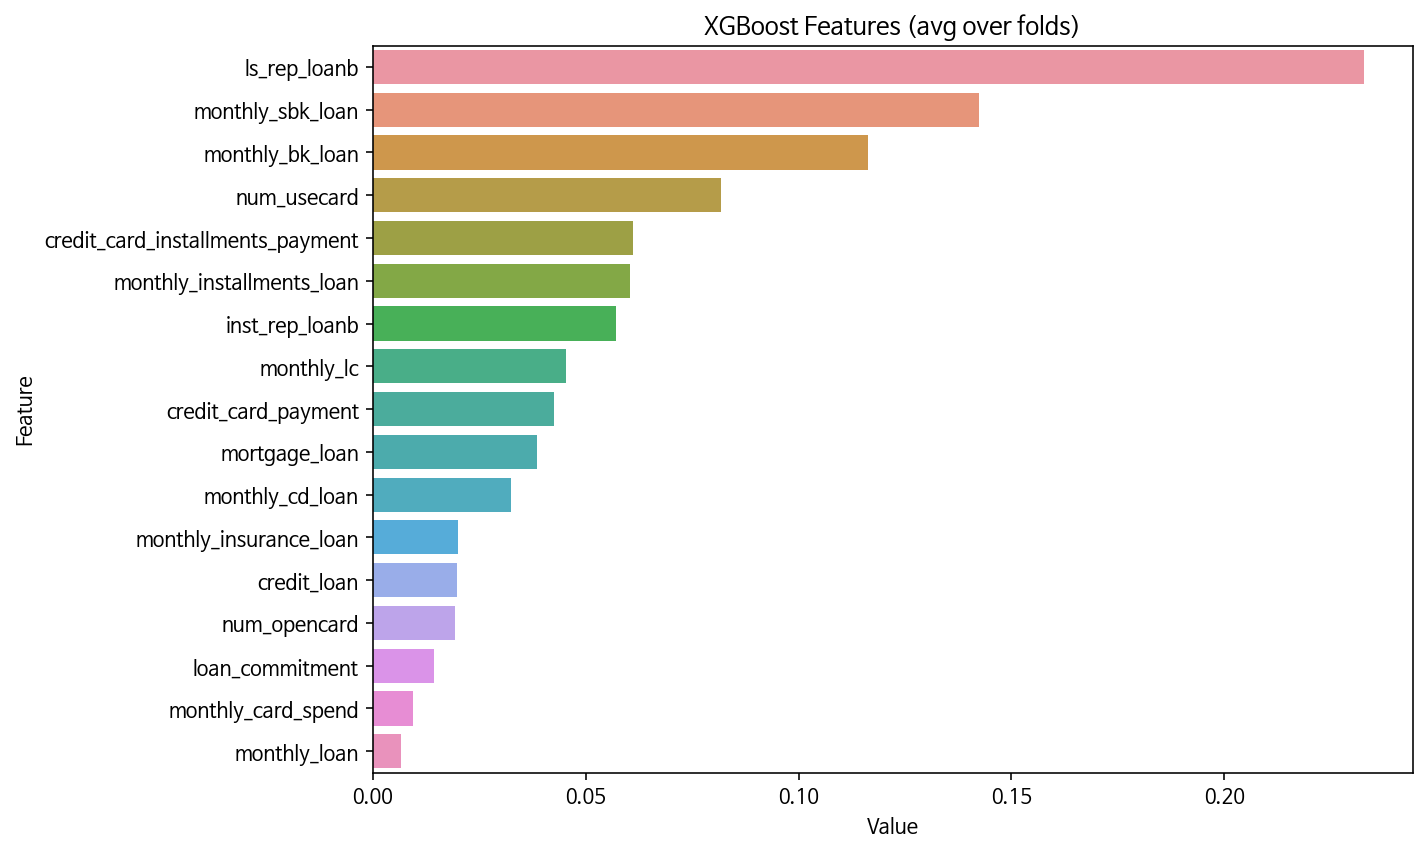

Weight,Feature
1.9419 ± 0.0681,num_usecard
0.2175 ± 0.0165,monthly_sbk_loan
0.1762 ± 0.0124,monthly_lc
0.1628 ± 0.0122,monthly_installments_loan
0.1302 ± 0.0066,num_opencard
0.0785 ± 0.0038,ls_rep_loanb
0.0733 ± 0.0033,monthly_bk_loan
0.0647 ± 0.0066,monthly_cd_loan
0.0571 ± 0.0055,monthly_insurance_loan
0.0558 ± 0.0019,inst_rep_loanb


In [23]:
from xgboost import XGBRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 10,
    'verbose': -1,
}

xgb_model = XGBRegressor(**params)
xgb_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    verbose=10,
)

feature_importance = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

perm = PermutationImportance(xgb_model).fit(val_split[cols_to_fit], val_split[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

###SHAP 중요도 분석
위의 중요도로는 변수가 얼마나 영향을 주는지만 알 수 있을 뿐, 신용도를 높이거나 낮추는 데에는 어떤 영향이 있는지 알 수 없다. SHAP를 사용해 변수의 값이 높을/낮을 때 신용도가 올라가는지 내려가는지를 보인다.

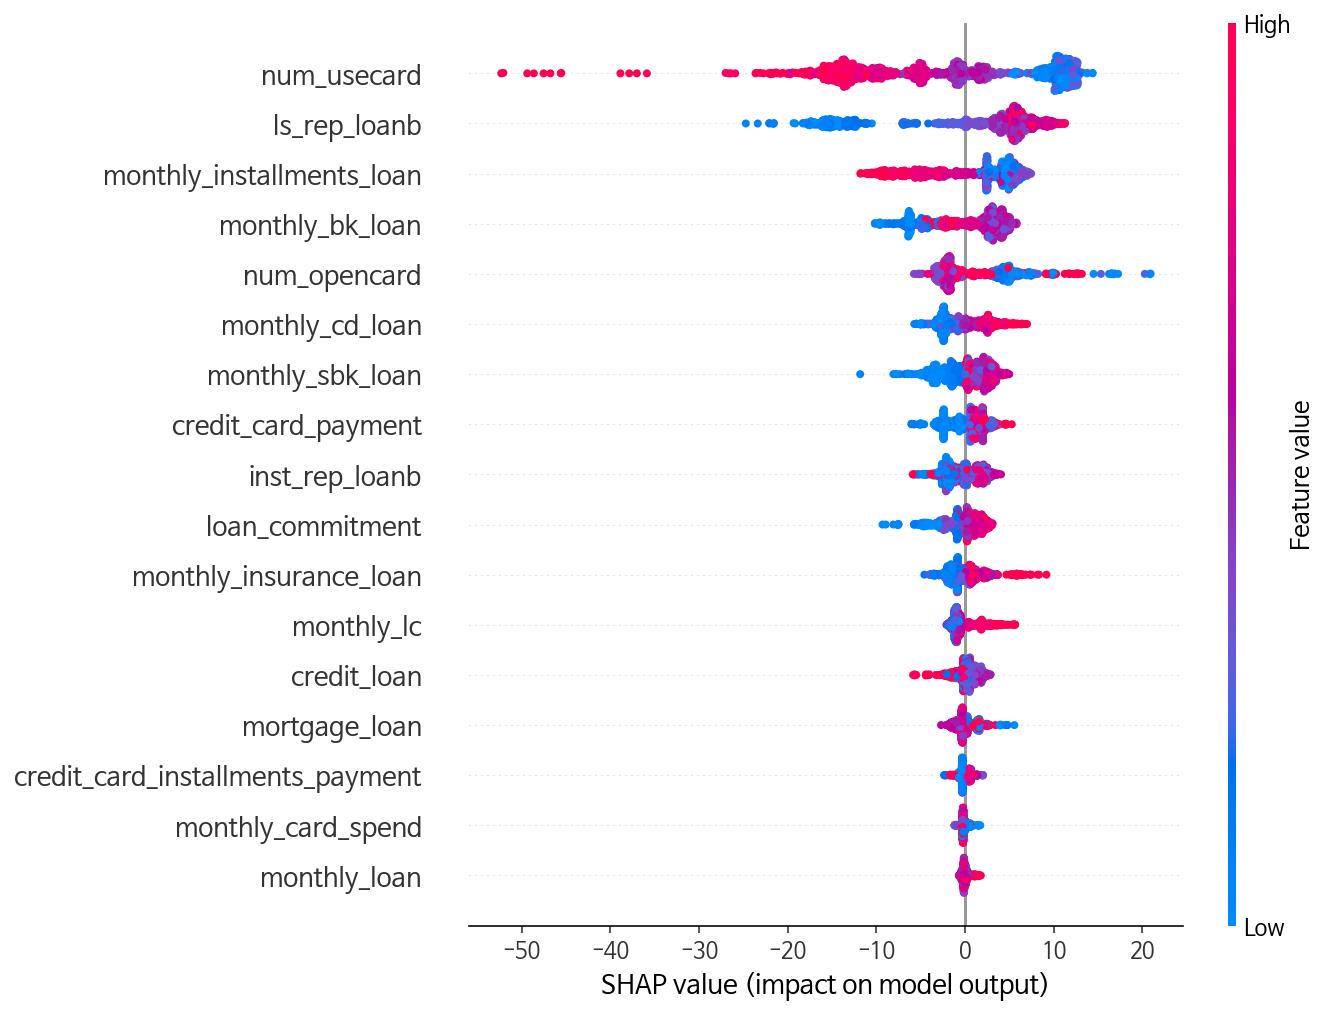

In [24]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

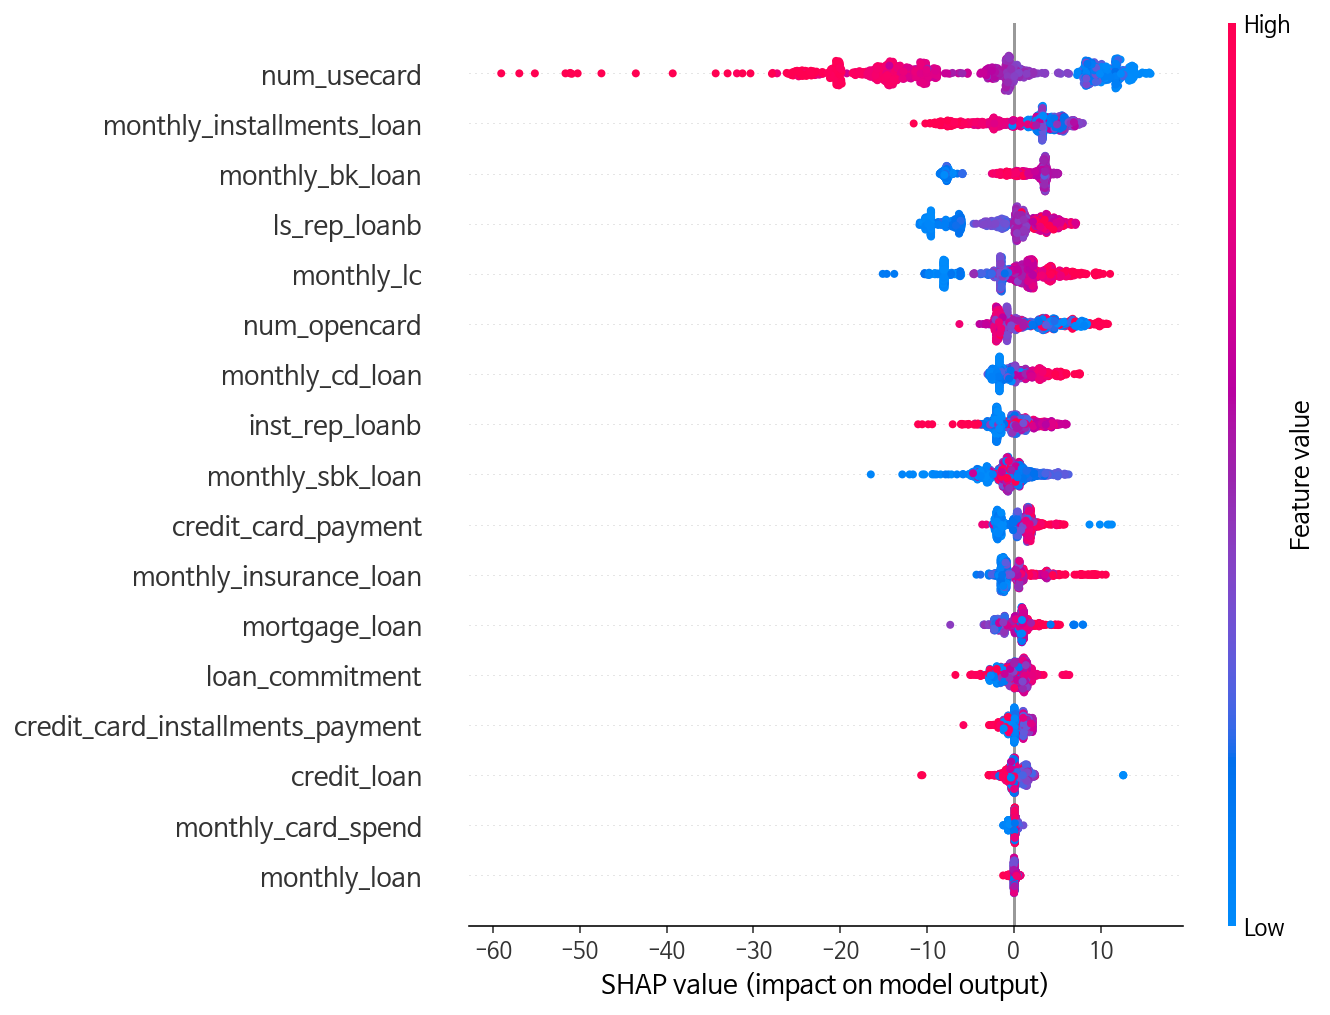

In [25]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

SHAP 분석에 따르면 사용 카드가 많을수록 신용도가 낮고 적을수록 높다고 예측한다.
하지만 사용카드의 수가 너무 큰 영향을 끼치는 것으로 보이기에 'num_usecard'와 'num_opencard'를 제외하고 다시 학습을 진행한다.

[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


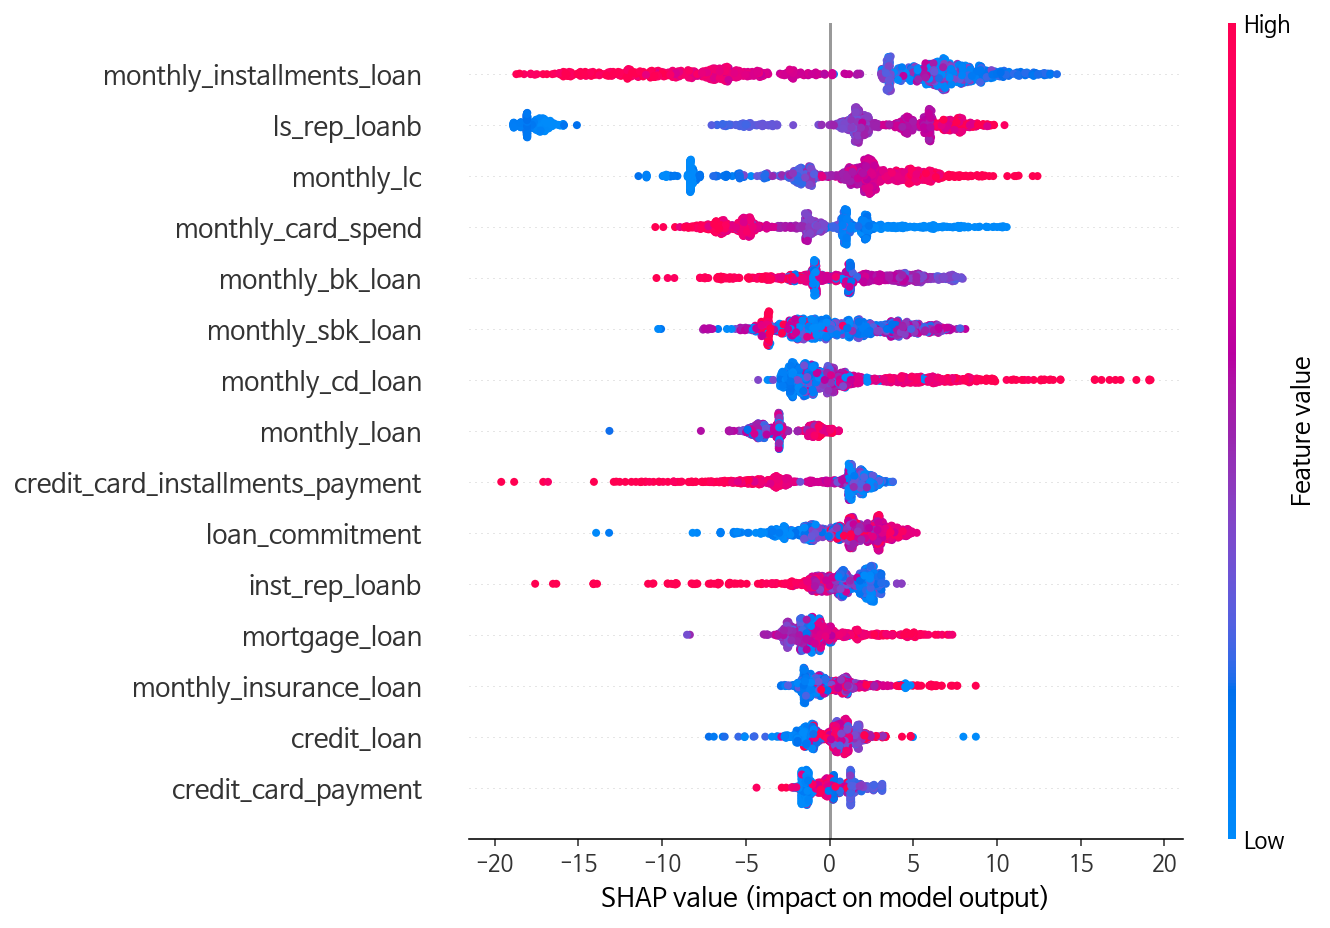

In [26]:
target = 'avg_score'
cols_to_drop = ['pop_cd','city','ages', 'sex', 'year_month', 'population','avg_rat', target]+['num_usecard', 'num_opencard']
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]
train_split, val_split = train_test_split(train, test_size=0.3)

xgb_model = XGBRegressor(**params)
xgb_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    verbose=0,
)

feature_importance = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

나머지 변수들을 토대로 신용도를 추정하자면 비례관계가 불확실한(값의 높고 낮음이 혼재된) 변수를 제외하면

- 할부금융 대출이 적을수록
- 일시상환대출 잔여금액이 많을수록
- 월간 카드 사용량이 적을수록
- 월간 카드 대출량이 많을수록
- 신용카드 사용금액이 적을수록
- 대출금액 총합이 많을수록

신용도가 높게 추정된다.

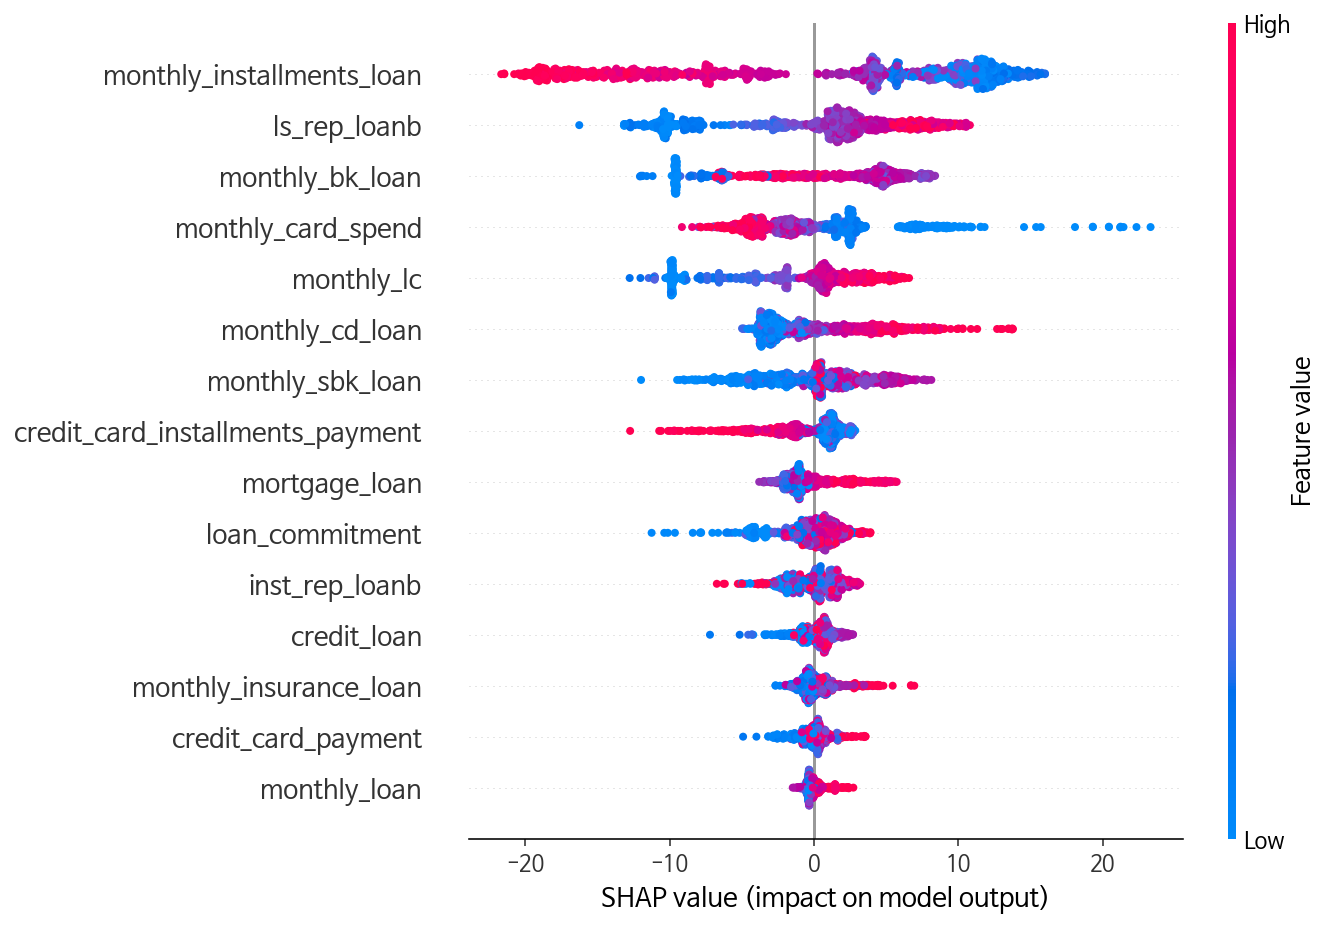

In [27]:
target = 'avg_score'
cols_to_drop = ['pop_cd','city','ages', 'sex', 'year_month', 'population','avg_rat', target]+['num_usecard', 'num_opencard']
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]
train_split, val_split = train_test_split(train, test_size=0.3)

lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    verbose=0,
)

feature_importance = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])
